In [1]:
## Here I will attempt to replicate the results found in Bacci et al. 2003 and 2006.
# main results are:
#   - inhibitory autapses produced more consistent firing frequencies over the duration of the spike train
#   - spike regularity was improved.
#   - These improvements occurred even in noise. 


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from AQUA_class import AQUA
from plotting_functions import *

import seaborn as sns
sns.set_theme(style = "white")

ModuleNotFoundError: No module named 'AQUA_class'

## Results on inhibitory autapses in FS interneurons.

#### Functional autaptic neurotransmission in Fast-Spiking Interneurons: A Novel Form of Feedback Inhibition in the Neocortex (doi: 10.1523/JNEUROSCI.23-03-00859.2003)

#### Enhancement of Spike-timing Precision by Autaptic Transmission in Neocortical Inhibitory Interneurons (DOI 10.1016/j.neuron.2005.12.014)

### Paper results:

Part 1 (Bacci 2003): Autapse made it harder to generate a second spike. They initiated a spike (1 ms pulse), then second pulse 10 ms later with increasing amplitude.

Part 2 (Bacci 2003): Frequency of the initial doublet is decreased with the inhibitory autapse. The train is elicited by step depolarization of varying amplitudes. The frequency over the course of the spike train is flatter than with no autapse. This one might need to include noise in the signal.

Part 3 (Bacci 2006): Autaptic inhibition reduces spikes jitter during a spike train. Spike jitter is defined as the standard deviation of difference in time between spikes.

Our model doesn't account for short-term depression of the autapse.

### Simulation results:

Part 1: The second pulse needs to be slightly higher to make the autaptic neuron fire. Can check whether this corresponds to the peak autaptic current directly or not. These simulated results correspond very closely to the results shown in fig. 5B (in Bacci 2003). 

Part 2: Overall, the autapse means the neuron fires at a lower firing rate. Additionally, the initial doublet tends to match the frequency at later times when an autapse is present creating a flatter frequency curve. Non-autaptic neuron has a fast initial doublet and then the neuron equilibrates. Also of note, the non-autaptic curves seem to be more noisy, where as autaptic neurons have more reliable firing patterns. This is observed also in Bacci et al. 2006 and explored more later. These results are more or less similar to those shown in the fig. 6B-C. Slight difference as frequency curve goes to decrease continuously in the real neuron. The plot of doublet frequencies (fig. 6C) is somewhat linear here too.

Part 3: The autapse produces less jitteriness in the spike timing during the train. This makes the autaptic neuron more robust to noise in the incoming signal. This result corresponds to that found in the Bacci et al 2006.


It could be that autapses allow for a more robust rate code. Fairhall et al. 2001 suggests that different features of firing activity encodes different aspects of the time-dependent signal. Also a recent paper about how neurons allocate resources towards global or local goals.

Could be that short-term depression of the autapse is leading to slightly different results, but this seems to capture the essential behaviour.

#### Part 1: paired current pulses (fig. 5)

In [ ]:
# Simulation setup.

# Large enough f will shift the behaviour of the system to bursting

# FS neuron parameters
a = 0.1
b = 0.2
c = -65
d = 2

#autaptic parameters
e = 0.14    # Bacci et al. 2003
f = -4      # negative for inhibitory interneuron
tau = 10    # ms (Bacci et al. 2003)

#simulation parameters
T = 1       # s
dt = 0.01   # ms
# N_iter = int(T*1000/dt)

# Initial values
x_start = np.array([-70., 0., 0.])
t_start = np.array([0.])

Neuron_free = AQUA(a, b, c, d) # e, f, tau set to 0 automatically
Neuron_autapse = AQUA(a, b, c, d, e, f, tau)



In [ ]:
## Start with simulation of responses to the current pulses.

# Injected current
I_1 = 20.0        # minimum to generate the first spike, for reference later.
I_2 = np.arange(30, 18.0, -0.25)
pulse_duration = 1 # ms
time_delays = tau  # only 1 time delay was considered which coincides with the autapse

# Create a Dataframe.
cols = ['I_2', 'autapse', 'spike']
N_rows = 2*len(I_2)
np_data = np.zeros((N_rows, 3))
df = pd.DataFrame(data = np_data, columns = cols)

In [ ]:

N = 0

for i in I_2:
    #Define the input current pulsed on new params.
    I_inj = np.concatenate([np.zeros(30000),
                            I_1*np.ones(int(pulse_duration/dt)), 
                            np.zeros(int(tau/dt)), 
                            i*np.ones(int(pulse_duration/dt)), 
                            np.zeros(20000)])

    N_iter = np.shape(I_inj)[0]

    # Re-initialise for each run.
    Neuron_free.Initialise(x_start, t_start)        #  Initial values
    Neuron_autapse.Initialise(x_start, t_start)     #  initial values

    # Generate responses
    X_free, T_free, spikes_free = Neuron_free.update_RK2(dt, N_iter, I_inj)
    X_autapse, T_autapse, spikes_autapse = Neuron_autapse.update_RK2(dt, N_iter, I_inj)

    np_data[N]   = np.array([[i, 0, len(spikes_free)]])
    np_data[N+1] = np.array([[i, 1, len(spikes_autapse)]])
    
    N += 2
print(df)



      I_2  autapse  spike
0   30.00      0.0    2.0
1   30.00      1.0    2.0
2   29.75      0.0    2.0
3   29.75      1.0    2.0
4   29.50      0.0    2.0
..    ...      ...    ...
91  18.75      1.0    1.0
92  18.50      0.0    1.0
93  18.50      1.0    1.0
94  18.25      0.0    1.0
95  18.25      1.0    1.0

[96 rows x 3 columns]


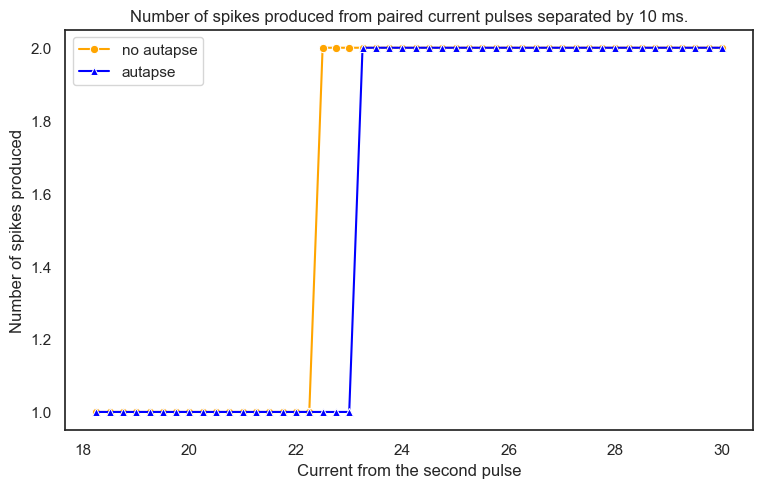

In [ ]:
## Take away: the autapse makes it slightly harder to fire a second spike at the 10 ms time-delay. 

fig1, ax1 = plt.subplots(1, 1, figsize = (8, 5))
fig1.tight_layout(pad = 2)
sns.lineplot(data = df[(df['autapse'] == 0)], x = 'I_2', y = 'spike', color = 'orange', marker = 'o', label = 'no autapse')
sns.lineplot(data = df[(df['autapse'] == 1)], x = 'I_2', y = 'spike', color = 'blue', marker = '^', label = 'autapse')

plt.xlabel('Current from the second pulse')
plt.ylabel('Number of spikes produced')

plt.title('Number of spikes produced from paired current pulses separated by 10 ms.')
plt.savefig(".\\Nov-2024_plots\\inhib_paired_pulses.png")

#### Part 2: step-depolarizations (fig. 6)

In [ ]:
# Similar to the previous experiment. With different step current heights.
# Simulation setup.

# FS neuron parameters
a = 0.1
b = 0.2
c = -65
d = 2

#autaptic parameters
e = 0.14    # Bacci et al. 2003
f = -4      # negative for inhibitory interneuron
tau = 10    # ms (Bacci et al. 2003)

#simulation parameters
T = 1       # s
dt = 0.01   # ms
N_iter = int(T*1000/dt)

# Initial values
x_start = np.array([-70., 0., 0.])
t_start = np.array([0.])

Neuron_free = AQUA(a, b, c, d) # e, f, tau set to 0 automatically
Neuron_autapse = AQUA(a, b, c, d, e, f, tau)


C:\Users\liamm\AppData\Local\Temp\ipykernel_7696\1103785124.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  hsv = cm.get_cmap('hsv', len(I_1)+1)
C:\Users\liamm\AppData\Local\Temp\ipykernel_7696\1103785124.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  jitter_df = pd.concat([jitter_df, free_df])


     I autapse  mean frequency   std dev
0  4.0       0       25.247662  0.797444
0  4.0       1       23.060615  0.324495
0  4.5       0       36.890246  0.688576
0  4.5       1       28.762208  0.284105
0  5.0       0       45.531360  0.676380
0  5.0       1       32.562143  0.243081
0  5.5       0       53.690402  0.723022
0  5.5       1       35.473267  0.237217
0  6.0       0       61.890920  0.728988
0  6.0       1       37.920183  0.186531
0  6.5       0       70.429731  0.770654
0  6.5       1       40.462994  0.338501


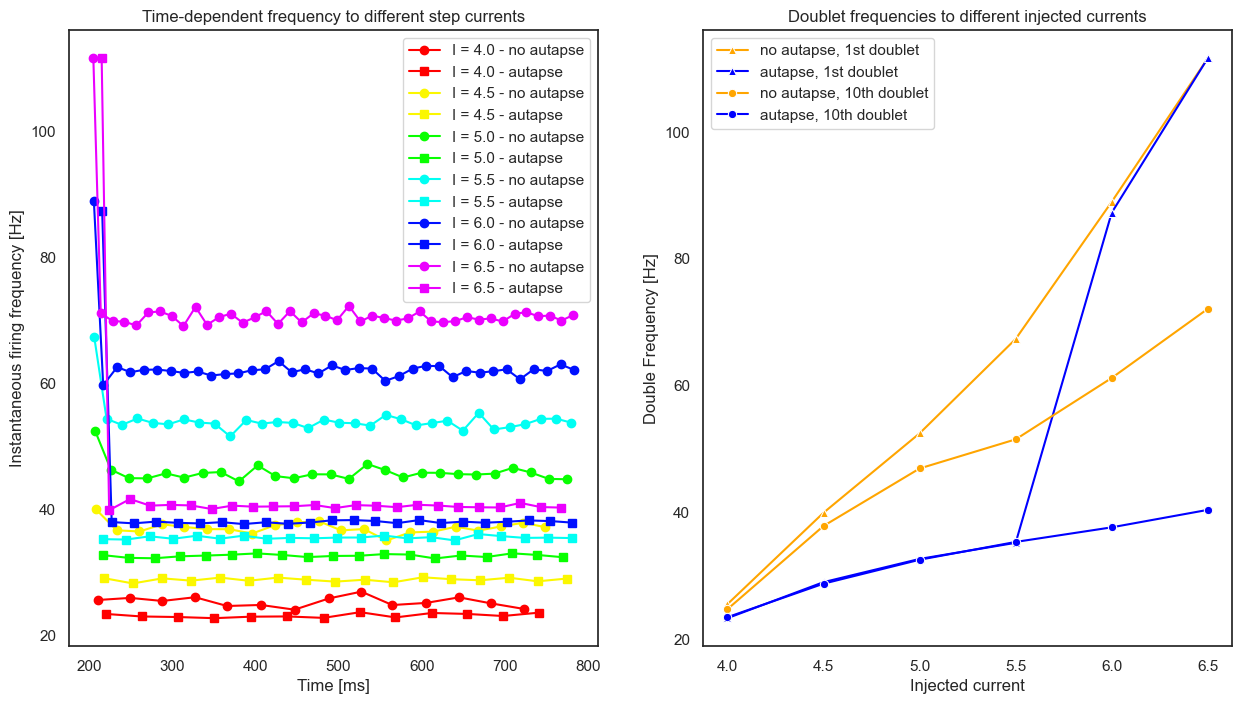

In [ ]:
# Simulation variables
# Will need to extract the spike times for each simulation.
# Just need to remember the 1st and 10th spike doublet. 
# There is a bifurcation at I = 7 with autapse in which the neuron produces bursts of doublets.
min_I = 4
max_I = 7.0
step = 0.5
I_1 = np.arange(min_I, max_I, 0.5)

hsv = cm.get_cmap('hsv', len(I_1)+1)
colors = hsv(np.arange(0, len(I_1)))

#define dataframe to store 1st and 10th doublets
cols = ['I', 'autapse', '1st doublet', '10th doublet']
N_rows = 2*len(I_1)
np_data = np.zeros((N_rows, 4))
df = pd.DataFrame(data = np_data, columns = cols)

jitter_cols = ['I', 'autapse', 'mean frequency', 'std dev']
jitter_df = pd.DataFrame(data = [], columns = jitter_cols)

fig4, ax4 = plt.subplots(1, 2, figsize = (15, 8))

for n, i in enumerate(I_1):
    I_noise = np.random.normal(loc = 0.0, scale = 1.0, size = N_iter)
    I_inj = np.concatenate([np.zeros(int(0.2*N_iter)),
                            i*np.ones(int(0.6*N_iter)),
                            np.zeros(int(0.2*N_iter))])
    I_inj += I_noise

    Neuron_free.Initialise(x_start, t_start)
    Neuron_autapse.Initialise(x_start, t_start)

    # Generate responses
    X_free, T_free, spikes_free = Neuron_free.update_RK2(dt, N_iter, I_inj)
    X_autapse, T_autapse, spikes_autapse = Neuron_autapse.update_RK2(dt, N_iter, I_inj)

    # instantaneous frequencies
    freq_free = 1000/np.ediff1d(spikes_free)
    freq_autapse = 1000/np.ediff1d(spikes_autapse)

    # Add mean and std dev to jitter_df
    free_df = pd.DataFrame(data = [[i, 0, np.mean(freq_free[1:]), np.std(freq_free[1:])]], columns = jitter_cols)
    aut_df = pd.DataFrame(data = [[i, 1, np.mean(freq_autapse[1:]), np.std(freq_autapse[1:])]], columns = jitter_cols)
    jitter_df = pd.concat([jitter_df, free_df])
    jitter_df = pd.concat([jitter_df, aut_df])


    ax4[0].plot(spikes_free[:-1], freq_free, color = colors[n], marker = 'o', label = 'I = ' + str(i) + ' - no autapse')
    ax4[0].plot(spikes_autapse[:-1], freq_autapse, color = colors[n], marker = 's', label = 'I = ' + str(i) + ' - autapse')

    np_data[2*n]   = np.array([i, 0, freq_free[0], freq_free[9]])
    np_data[2*n+1] = np.array([i, 1, freq_autapse[0], freq_autapse[9]])

ax4[0].legend()
sns.lineplot(data = df[df['autapse'] == 0], x = 'I', y = '1st doublet', color = 'orange', marker = '^', ax = ax4[1], label = "no autapse, 1st doublet")
sns.lineplot(data = df[df['autapse'] == 1], x = 'I', y = '1st doublet', color = 'blue', marker = '^', ax = ax4[1], label = "autapse, 1st doublet")
sns.lineplot(data = df[df['autapse'] == 0], x = 'I', y = '10th doublet', color = 'orange', marker = 'o', ax = ax4[1], label = "no autapse, 10th doublet")
sns.lineplot(data = df[df['autapse'] == 1], x = 'I', y = '10th doublet', color = 'blue', marker = 'o', ax = ax4[1], label = "autapse, 10th doublet")


ax4[0].set_xlabel('Time [ms]')
ax4[0].set_ylabel('Instantaneous firing frequency [Hz]')
ax4[0].set_title('Time-dependent frequency to different step currents')

ax4[1].set_xlabel('Injected current')
ax4[1].set_ylabel('Double Frequency [Hz]')
ax4[1].set_title('Doublet frequencies to different injected currents')

print(jitter_df)

plt.savefig(".\\Nov-2024_plots\\spike_jitter.png")


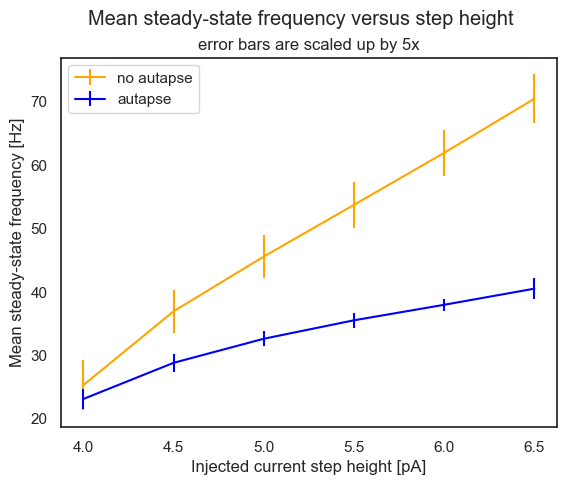

In [ ]:
## Work on jitter df to show the robustness of the neural response.
# Maybe just plot frequency versus input current with error bars.
#sns.lineplot(data = df[df['autapse'] == 1], x = 'I', y = '10th doublet', color = 'blue', marker = 'o', ax = ax4[1], label = "autapse, 10th doublet")
#first plot no autapse
x_free = jitter_df[jitter_df['autapse'] == 0]['I']
x_aut = jitter_df[jitter_df['autapse'] == 1]['I']

y_free = jitter_df[jitter_df['autapse'] == 0]['mean frequency']
y_aut = jitter_df[jitter_df['autapse'] == 1]['mean frequency']

free_err = jitter_df[jitter_df['autapse'] == 0]['std dev']
aut_err = jitter_df[jitter_df['autapse'] == 1]['std dev']

plt.errorbar(x_free, y_free, yerr = 5*free_err, color = 'orange', label = 'no autapse') #, marker = 'o')
plt.errorbar(x_aut, y_aut, yerr = 5*aut_err, color = 'blue', label = 'autapse') #, marker = 's')

plt.xlabel('Injected current step height [pA]')
plt.ylabel('Mean steady-state frequency [Hz]')
plt.suptitle('Mean steady-state frequency versus step height')
plt.title('error bars are scaled up by 5x')
plt.legend()
plt.savefig(".\\Nov-2024_plots\\mean_freq_w_error.png")

In [ ]:
# Simulation setup.

# Large enough f will shift the behaviour of the system to bursting

# FS neuron parameters
a = 0.1
b = 0.2
c = -65
d = 2

#autaptic parameters
e = 0.14    # Bacci et al. 2003
f = -4      # negative for inhibitory interneuron
tau = 10    # ms (Bacci et al. 2003)

#simulation parameters
T = 3       # s
dt = 0.01   # ms
N_iter = int(T*1000/dt)

# Initial values
x_start = np.array([-70., 0., 0.])
t_start = np.array([0.])

Neuron_free = AQUA(a, b, c, d) # e, f, tau set to 0 automatically
Neuron_autapse = AQUA(a, b, c, d, e, f, tau)

In [ ]:
## Testing the jitteriness change.

# Apply the same (noisy) step current to a neuron with and without autapse. Repeat this several times to get a distribution of spike times
# For each spike, calculate the standard deviation, this corresponds to the jitter of that spike.

# Plot jitteriness over time. I expect this to be flat. 

spike_times_free = np.zeros((10, 10))
spike_times_autapse = np.zeros((10, 10))


for i in range(10):
    I_height = 5
    I_noise = np.random.normal(loc = 0.0, scale = 0.25*I_height, size = N_iter)
    I_inj = np.concatenate([np.zeros(int(0.2*N_iter)),
                            I_height*np.ones(int(0.6*N_iter)),
                            np.zeros(int(0.2*N_iter))])
    I_inj += I_noise

    Neuron_free.Initialise(x_start, t_start)
    Neuron_autapse.Initialise(x_start, t_start)

    X_free, T_free, spikes_free = Neuron_free.update_RK2(dt, N_iter, I_inj)
    X_aut, T_aut, spikes_aut = Neuron_autapse.update_RK2(dt, N_iter, I_inj)

    spike_times_free[i, :] = spikes_free[2:12]
    spike_times_autapse[i, :] = spikes_aut[2:12]




Text(0.5, 1, 'Response of ordinary and autaptic neurons to a step current injection')

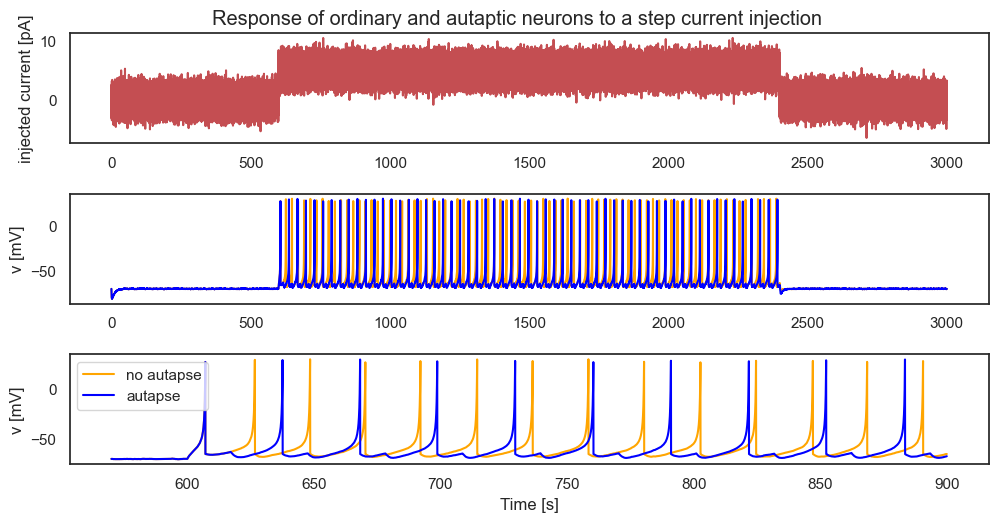

In [ ]:
#plot
fig, ax = plt.subplots(3, 1, figsize = (10, 5))
fig.tight_layout()
indices = range(int(0.19*N_iter), int(0.3*N_iter))

ax[0].plot(T_free, I_inj, c = 'r')
#ax[0].title.set_text('injected current')
#ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('injected current [pA]')

ax[1].plot(T_free, X_free[0], c = 'orange')
ax[1].plot(T_aut, X_aut[0], c = 'blue')
#ax[1].title.set_text("Full response")
#ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('v [mV]')

ax[2].plot(T_free[indices], X_free[0, indices], c = 'orange', label = 'no autapse')
ax[2].plot(T_aut[indices], X_aut[0, indices], c = 'blue', label = 'autapse')
#ax[2].title.set_text("Full response")
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('v [mV]')
ax[2].legend()

fig.suptitle("Response of ordinary and autaptic neurons to a step current injection", y = 1)

#### Plots of the jitter of spike times by spike number, also plot the deviation 

[0.54990999 0.71132552 0.64470536 0.70538287 0.7594498  0.89373374
 0.84919727 0.99298792 1.02264168 1.06483097]
[0.37237615 0.5006286  0.59112181 0.62520717 0.73494285 0.69088422
 0.92543233 0.83673174 0.95314007 1.03325699]


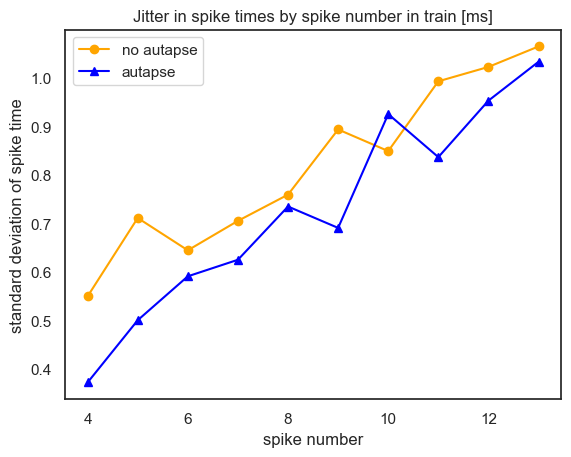

In [ ]:
# Now plot the jitter over time.

spike_num = np.arange(4, 14, 1)

free_mean = np.mean(spike_times_free, axis = 0)
free_std = np.std(spike_times_free, axis = 0)
print(free_std)
plt.plot(spike_num, free_std, c = 'orange', marker = 'o', label = 'no autapse')


aut_mean = np.mean(spike_times_autapse, axis = 0)
aut_std = np.std(spike_times_autapse, axis = 0)
print(aut_std)

plt.plot(spike_num, aut_std, c = 'blue', marker = '^', label = 'autapse')

plt.xlabel("spike number")
plt.ylabel("standard deviation of spike time")
plt.title("Jitter in spike times by spike number in train [ms]")
plt.legend()

45.5661993578646
0.7727904756922844
[[32.8731098  32.25806452 32.01024328 32.31017771 32.50975293 32.07184092
  33.0141961  32.45699448 32.32062056]
 [32.72251309 32.91639236 32.5732899  32.67973856 32.44646334 32.99241175
  32.41491086 32.50975293 32.86230693]
 [32.64773098 32.65839321 32.70111184 32.97065612 32.42542153 32.28931224
  32.38341969 32.25806452 32.06155819]
 [32.41491086 32.8731098  32.17503218 32.97065612 33.23363244 32.86230693
  32.42542153 33.02509908 32.13367609]
 [32.80839895 31.79650238 32.67973856 32.2997416  32.78688525 32.2684737
  32.11303789 32.2684737  33.02509908]
 [32.70111184 32.11303789 32.64773098 32.5414904  32.49918752 32.18538783
  32.60515161 32.4780773  32.404407  ]
 [32.46753247 32.42542153 32.98153034 32.31017771 32.82994091 31.74603175
  32.50975293 32.32062056 31.93867774]
 [32.23726628 32.59452412 32.32062056 32.404407   32.72251309 32.79763857
  32.50975293 32.5732899  32.35198965]
 [33.07972213 32.31017771 33.00330033 32.43593902 32.14400514

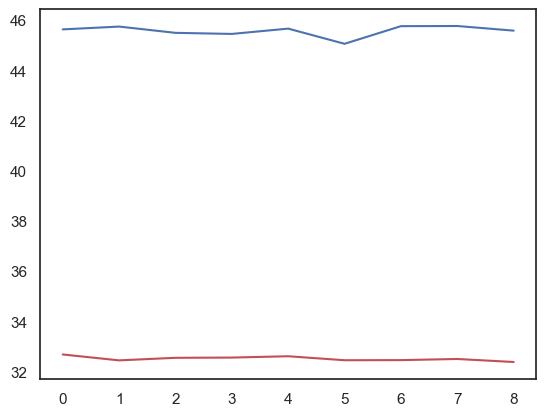

In [ ]:
# Now look at the deviation from the mean frequency during the train.


freq_free = 1000/np.diff(spike_times_free, axis = 1)
freq_aut = 1000/np.diff(spike_times_autapse, axis = 1)


print(np.mean(freq_free))
print(np.std(freq_free))

print(freq_aut)
print(np.mean(freq_aut))
print(np.std(freq_aut))

plt.plot(np.mean(freq_free, 0), c = 'b')
plt.plot(np.mean(freq_aut, 0), c = 'r')

